# PLOT VARIÁVEIS DA BOIA

## temperatura do ar e da superfície do mar, umidade relativa, pressão atmosférica, vento em u e v, salinidade

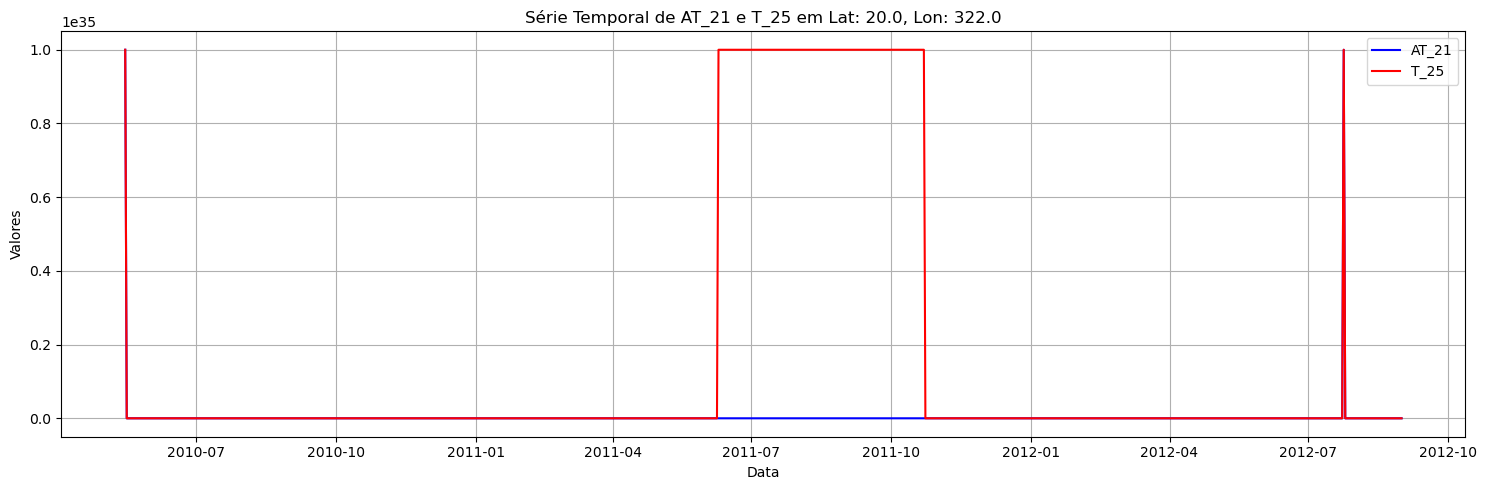

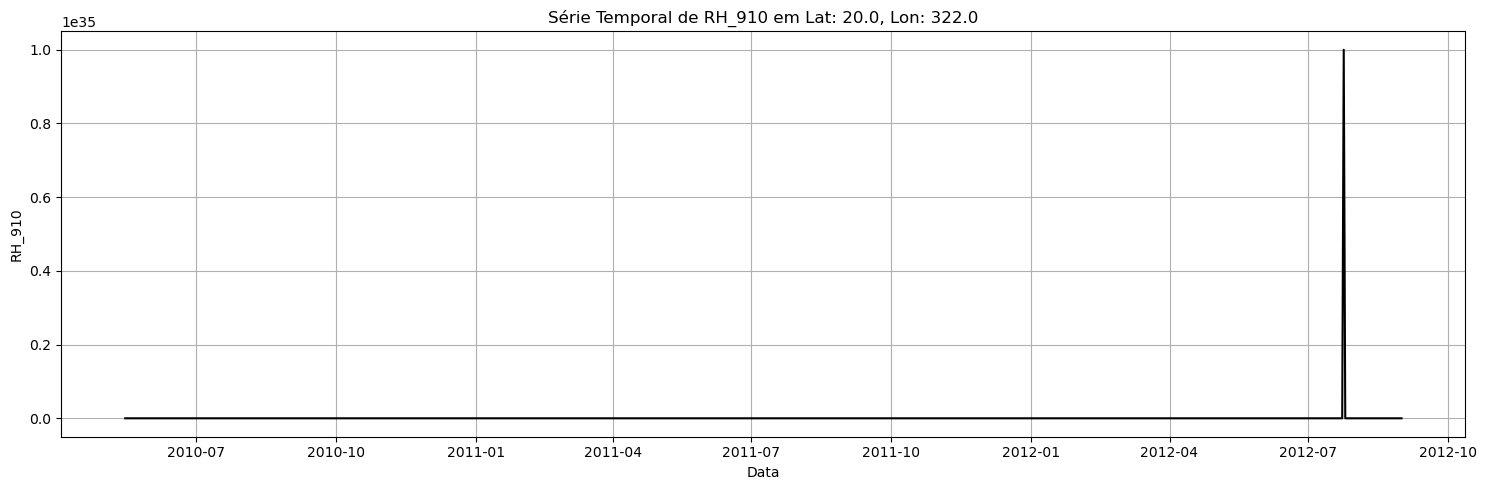

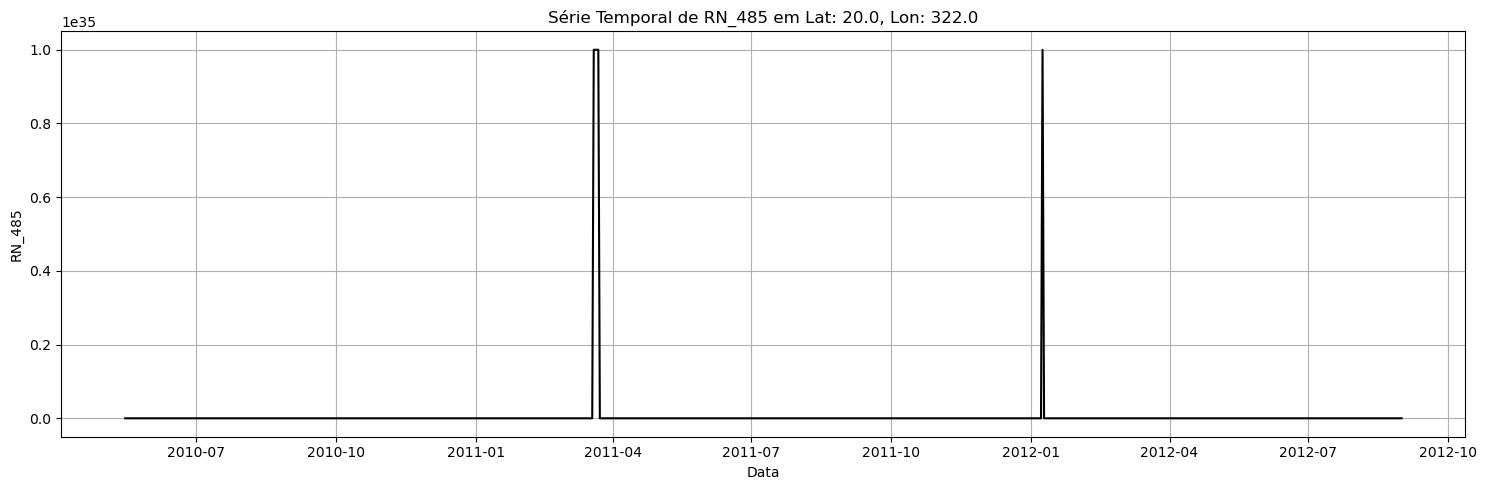

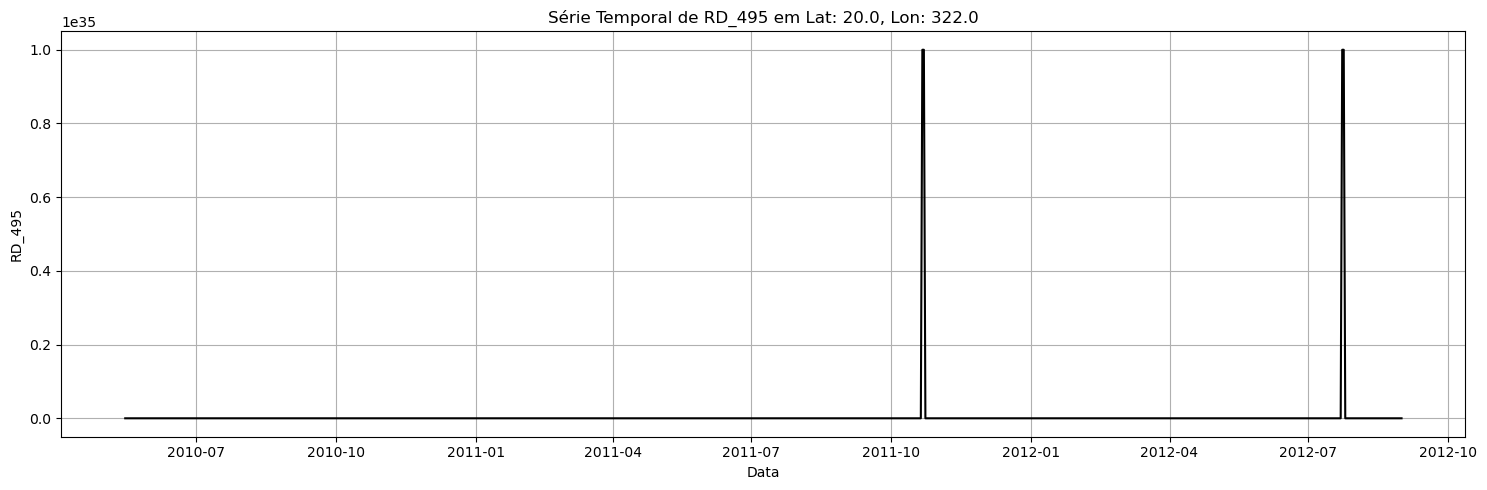

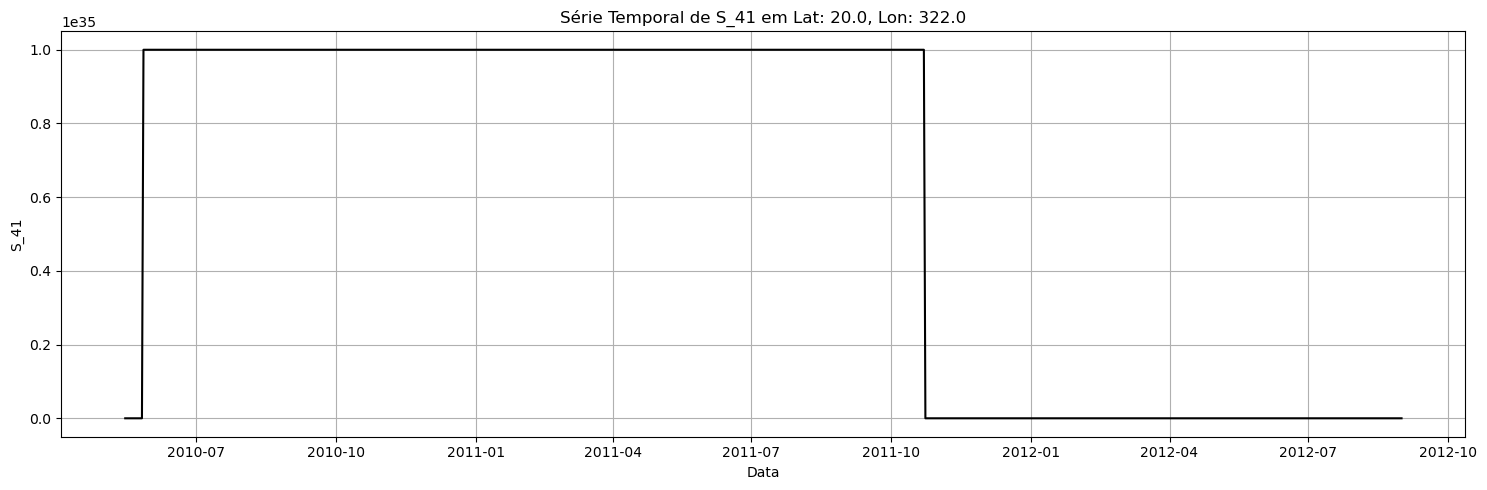

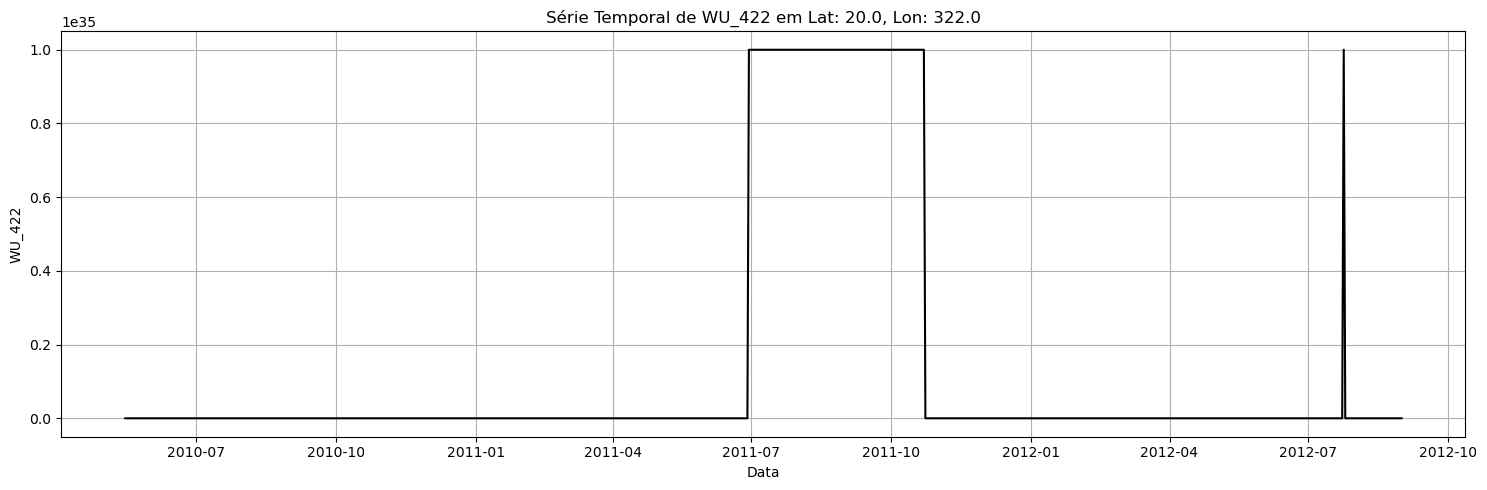

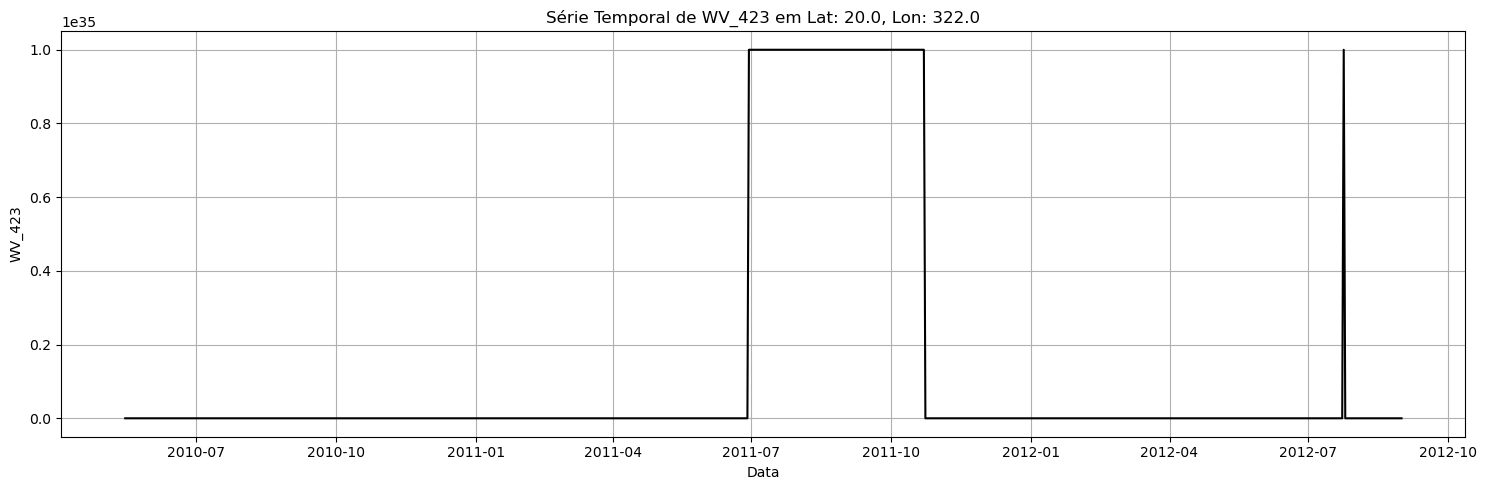

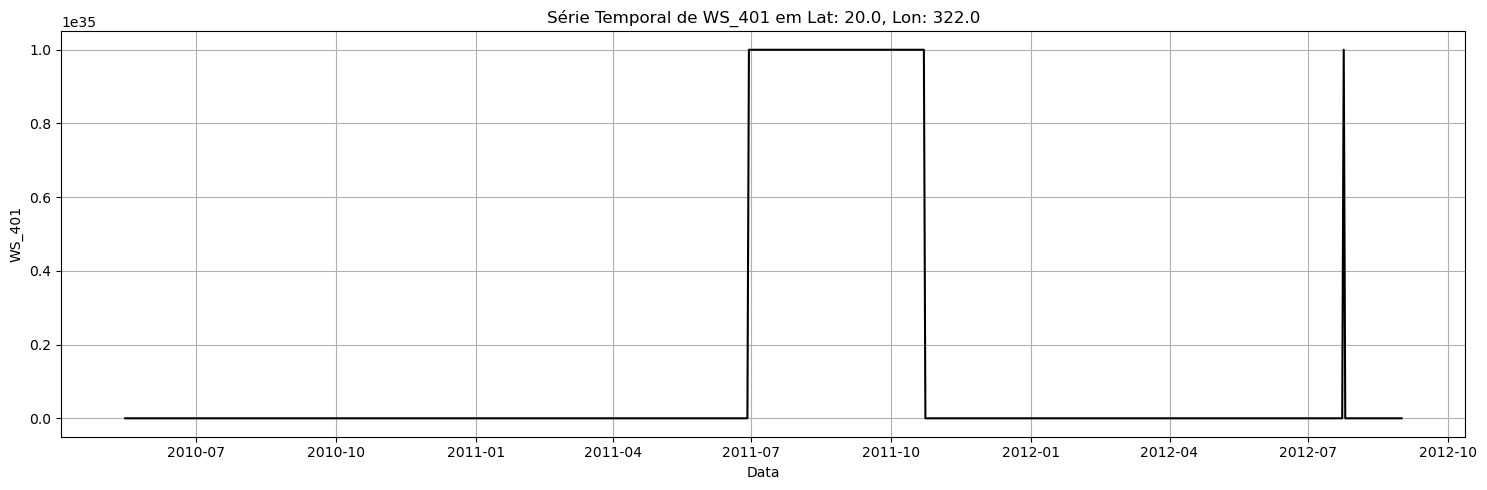

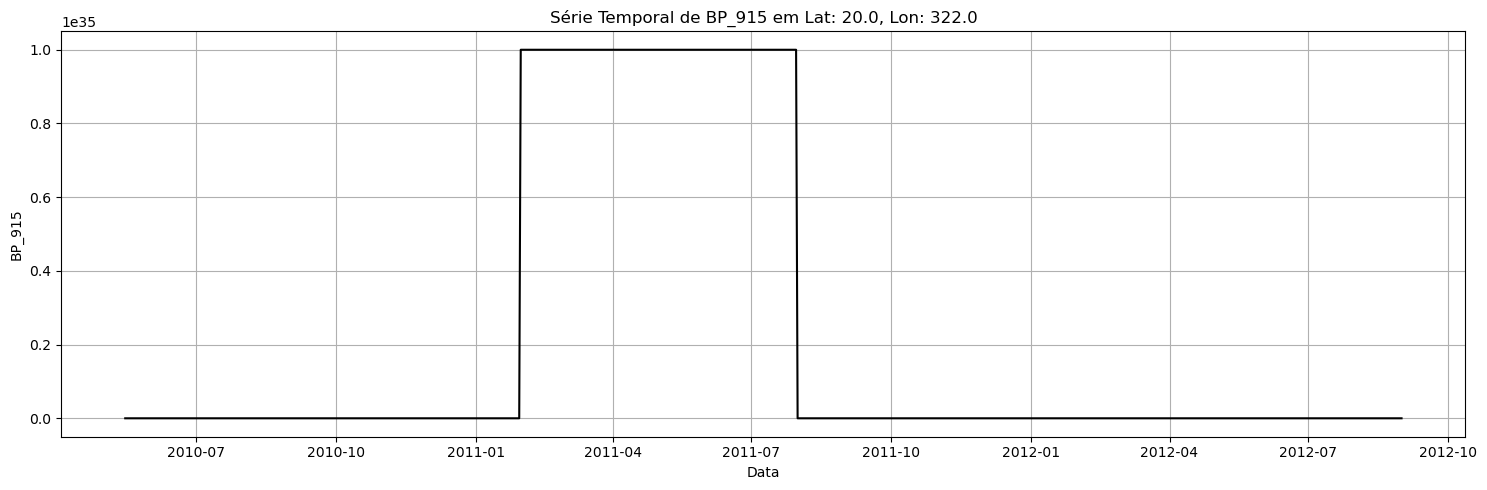

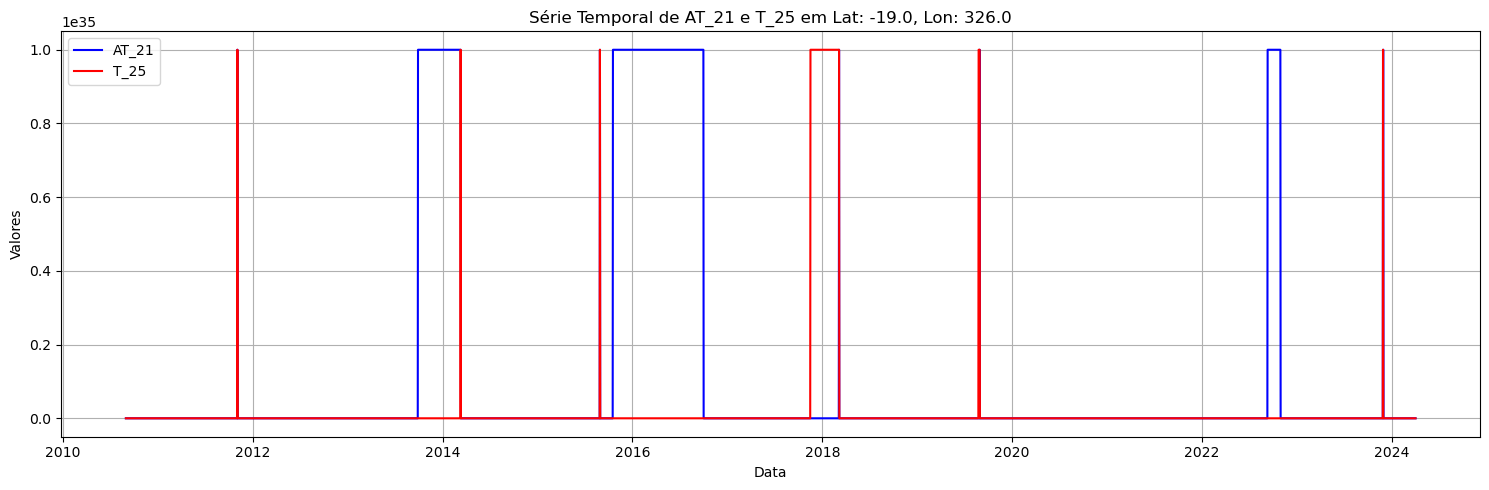

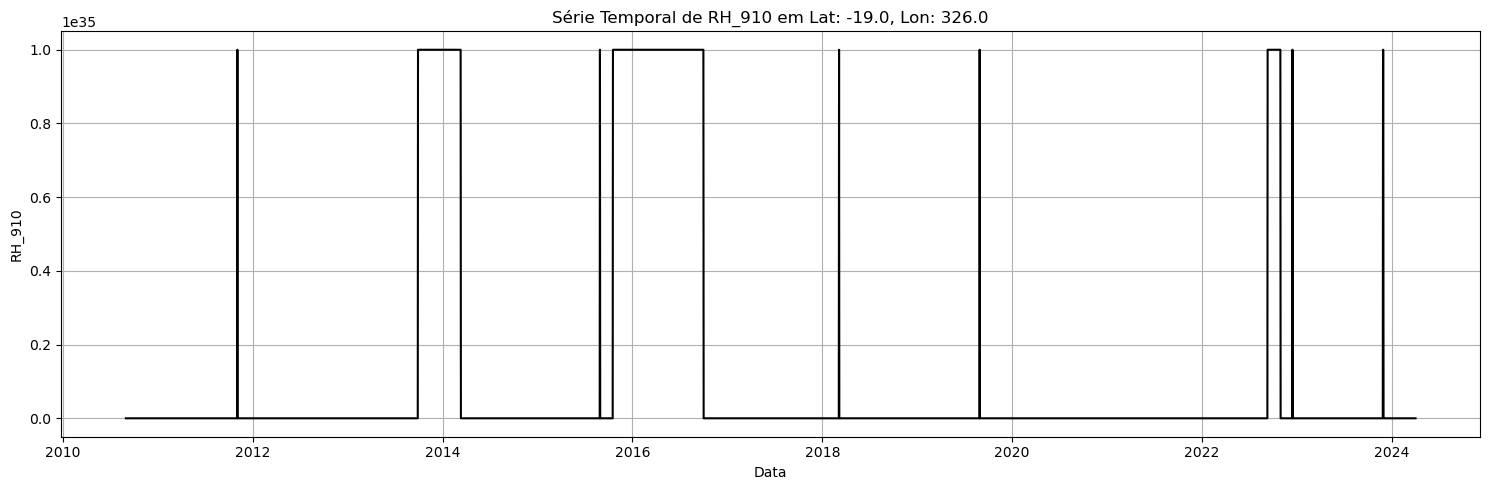

KeyboardInterrupt: 

In [8]:
import numpy as np
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os  # Para manipular caminhos de diretórios e arquivos

# Defina o caminho da pasta onde estão seus arquivos NetCDF
caminho_pasta = "/home/leticia/Documentos/MESTRADO/Dados_diarios_boias/"  # Certifique-se de que o caminho está correto

def ler_dados(arquivo, variaveis_interesse):
    ds = nc.Dataset(arquivo)
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
    tempo = ds.variables['time'][:]  # A variável 'time' geralmente está em dias desde uma data base

    datas = nc.num2date(tempo, units=ds.variables['time'].units)

    # Convert cftime.DatetimeGregorian objects to strings and then to pandas datetime objects
    datas = [str(date) for date in datas]  # Convert to string
    datas = pd.to_datetime(datas)  # Now convert the list of strings to pandas datetime objects

    fill_value = 1e35  # Valor usado para identificar dados ausentes

    dfs = {}
    for var in variaveis_interesse:
        if var in ds.variables:  # Checa se a variável está no arquivo
            dados = ds.variables[var][:]
            if var != "T_25":
                dados = np.where(dados == fill_value, np.nan, dados)
            dados = dados.squeeze()  # Remove eixos de tamanho 1

            df = pd.DataFrame({
                'Data': datas,
                var: dados
            })

            df.set_index('Data', inplace=True)

            dfs[var] = df

    return lat.mean(), lon.mean(), dfs

def plotar_series_temporais(dfs, lat, lon, diretorio_salvar=None):
    # Verifica se as variáveis AT_21 e T_25 existem para plotá-las juntas
    if "AT_21" in dfs and "T_25" in dfs:
        plt.figure(figsize=(15,5))
        plt.plot(dfs["AT_21"].index, dfs["AT_21"]["AT_21"], label="AT_21", color='blue')
        plt.plot(dfs["T_25"].index, dfs["T_25"]["T_25"], label="T_25", color='red')
        plt.xlabel('Data')
        plt.ylabel('Valores')
        titulo = f"Série Temporal de AT_21 e T_25 em Lat: {lat:.1f}, Lon: {lon:.1f}"
        plt.title(titulo)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if diretorio_salvar:
            plt.savefig(os.path.join(diretorio_salvar, f"AT_21_T_25_{lat:.1f}_{lon:.1f}.png"))
        plt.show()

    # Plota as demais variáveis
    for var, df in dfs.items():
        if var not in ["AT_21", "T_25"]:  # Ignora AT_21 e T_25 pois já foram plotadas
            plt.figure(figsize=(15,5))
            plt.plot(df.index, df[var], label=var, color='k')
            plt.xlabel('Data')
            plt.ylabel(var)
            titulo = f"Série Temporal de {var} em Lat: {lat:.1f}, Lon: {lon:.1f}"
            plt.title(titulo)
            plt.grid(True)
            plt.tight_layout()
            if diretorio_salvar:
                plt.savefig(os.path.join(diretorio_salvar, f"{var}_{lat:.1f}_{lon:.1f}.png"))
            plt.show()
# Definição das variáveis de interesse
variaveis_interesse = ["AT_21", "T_25", "RH_910", "RN_485", "RD_495", "S_41", "WU_422", "WV_423", "WS_401", "BP_915"]

# Caminho onde os gráficos serão salvos
diretorio_salvar = "/home/leticia/Documentos/MESTRADO/Dados_diarios_boias/figuras"

# Certifique-se de que o diretório existe
os.makedirs(diretorio_salvar, exist_ok=True)

#arquivos_netCDF = glob.glob(caminho_pasta)

arquivos_netCDF = glob.glob(caminho_pasta + "*.cdf")
for arquivo in arquivos_netCDF:
    lat, lon, dfs = ler_dados(arquivo, variaveis_interesse)
    plotar_series_temporais(dfs, lat, lon, diretorio_salvar=diretorio_salvar)


### Cálculo da magnitude do vento e plot das figuras

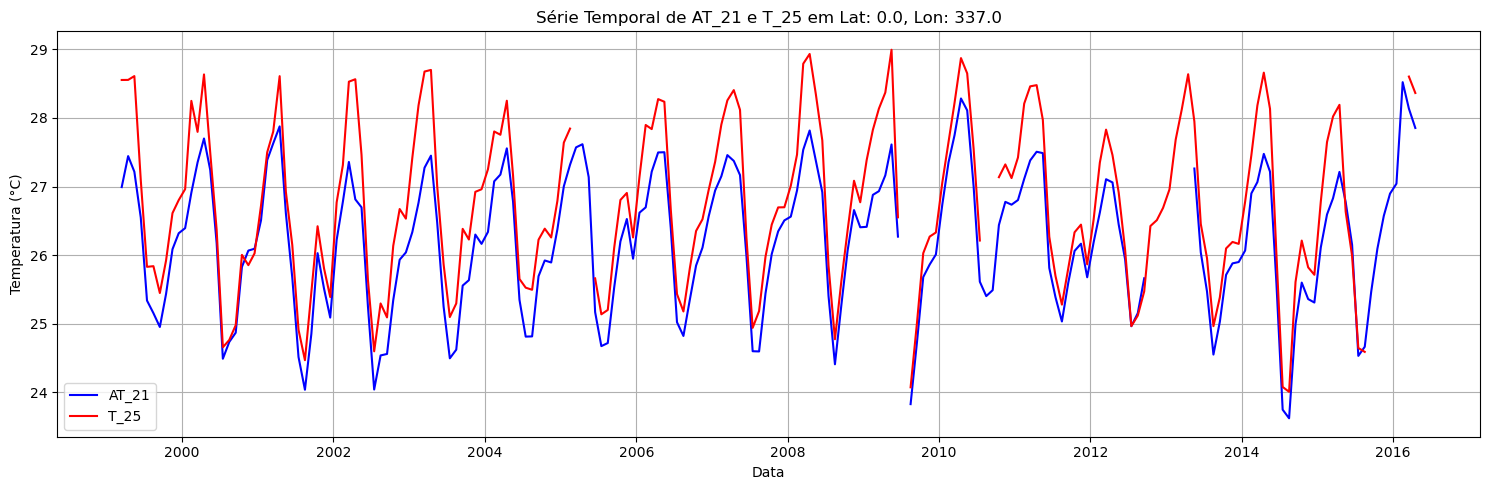

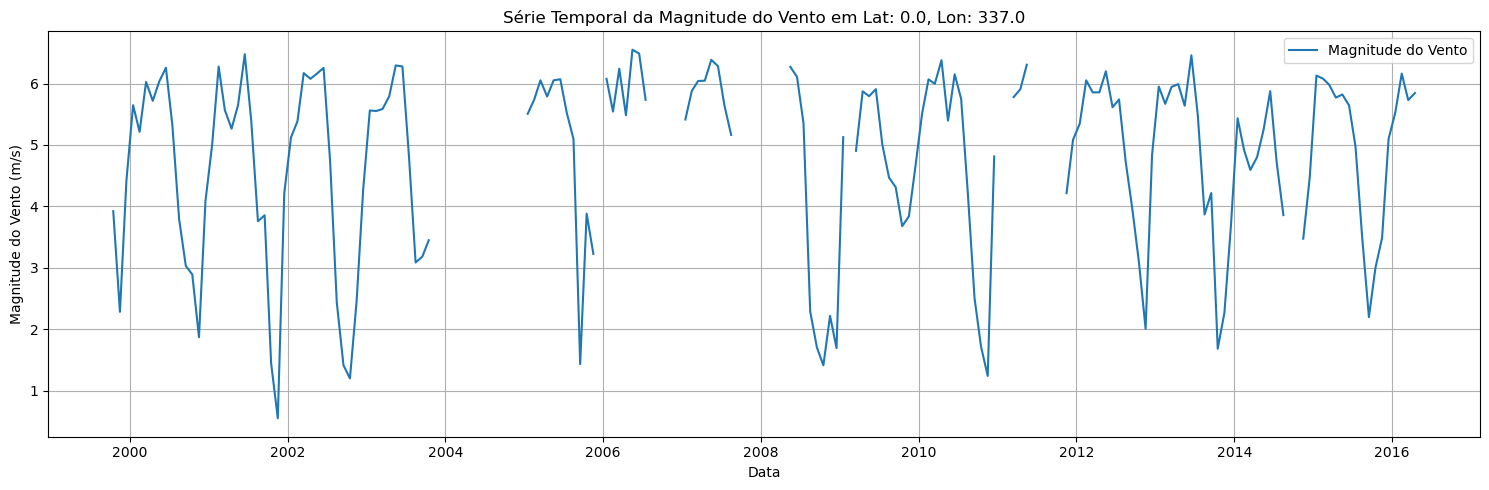

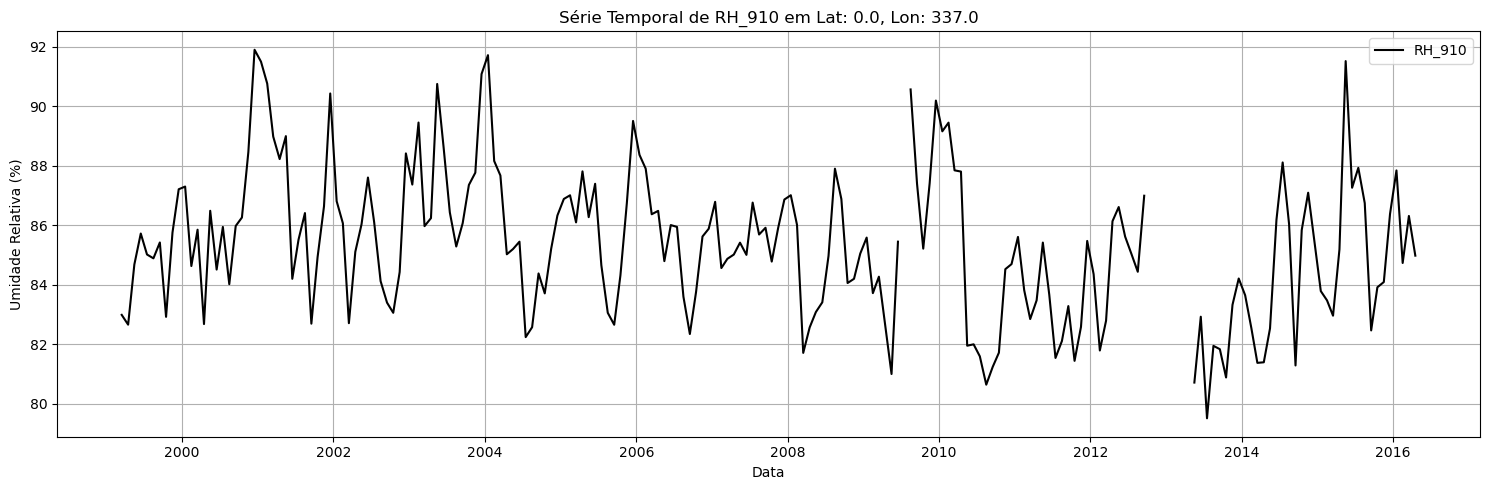

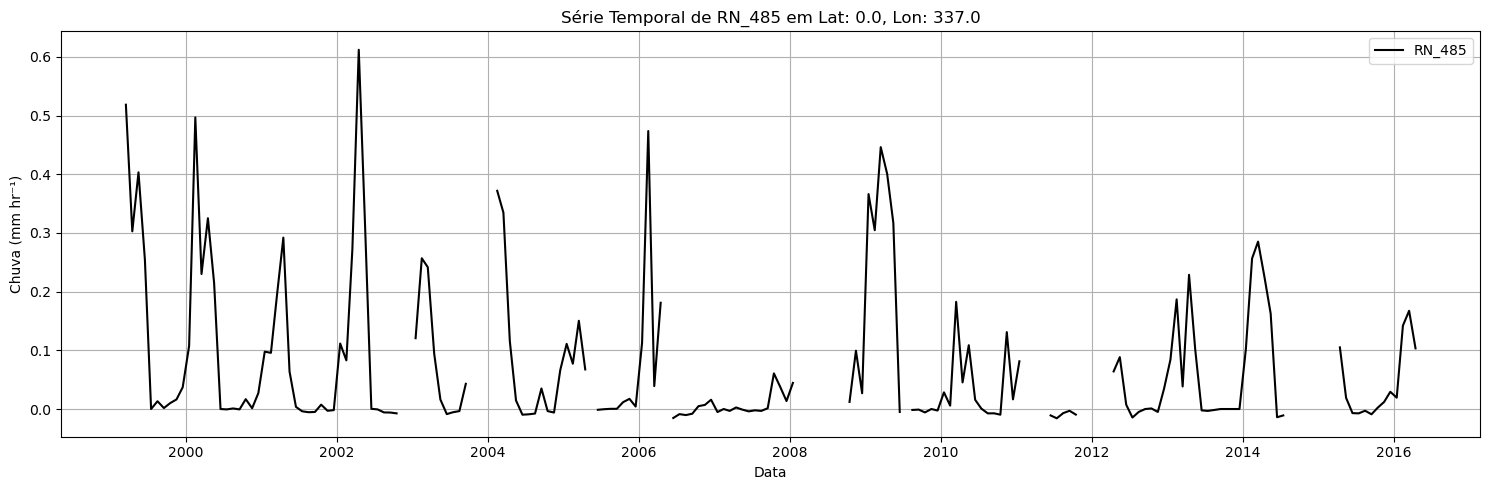

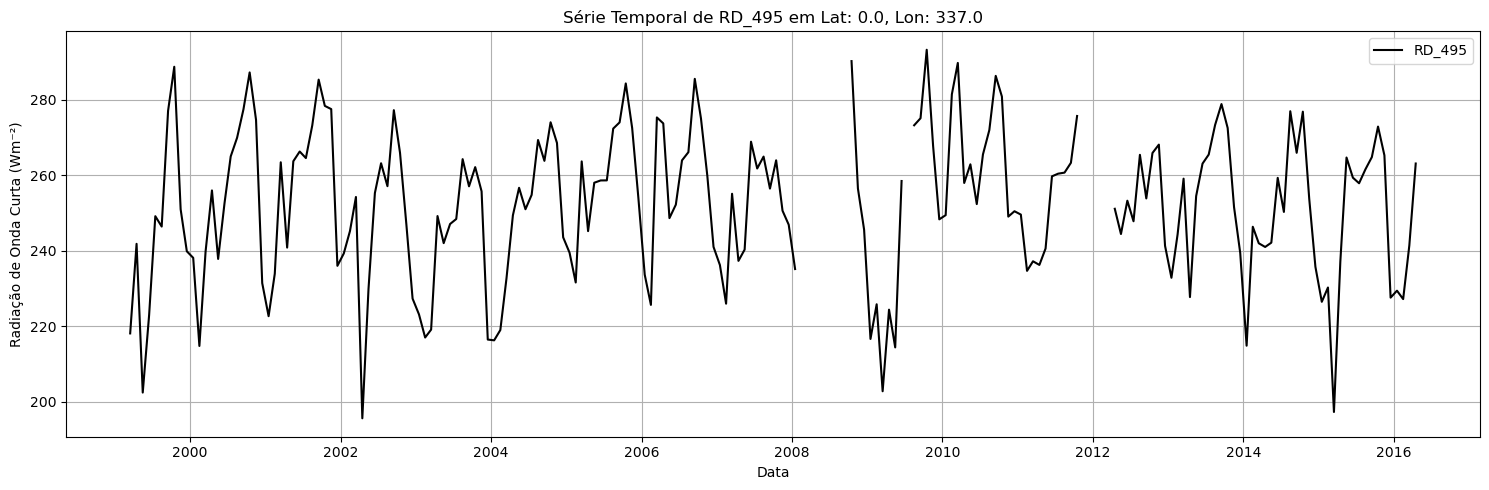

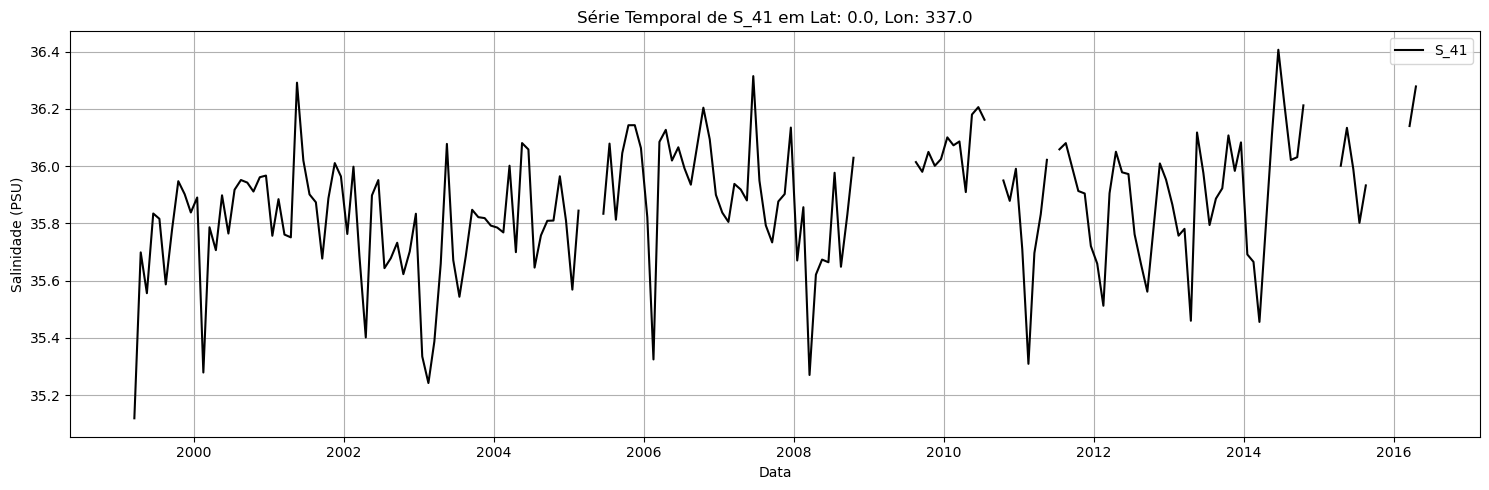

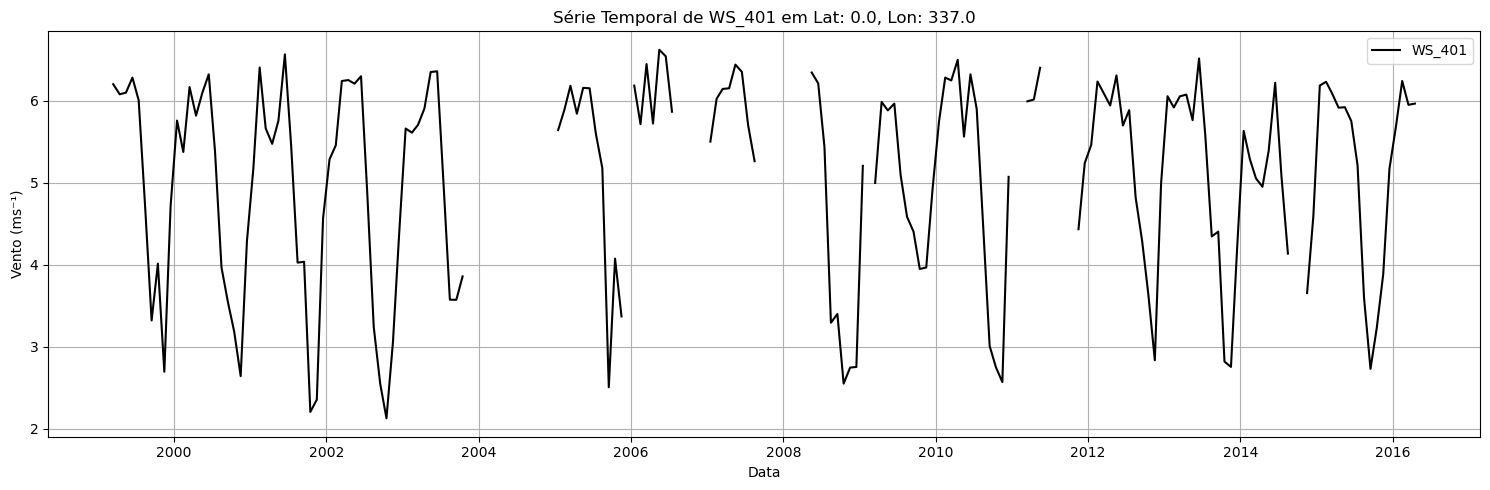

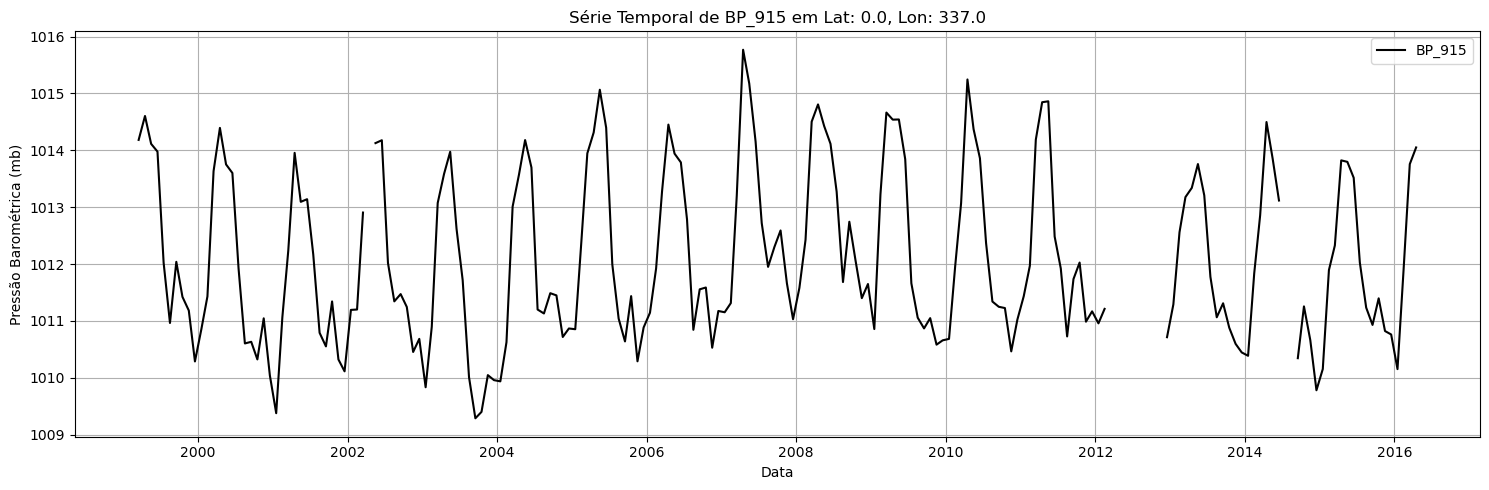

Arquivo CSV criado: /home/leticia/Documentos/MESTRADO/quali/Dados/figuras/0n23w/dados_boias_0n23w_interp.csv


In [22]:
import numpy as np
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os  # Para manipular caminhos de diretórios e arquivos

def ler_dados(arquivo, variaveis_interesse):
    ds = nc.Dataset(arquivo)
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
    tempo = ds.variables['time'][:]  # A variável 'time' geralmente está em dias desde uma data base

    datas = nc.num2date(tempo, units=ds.variables['time'].units)
    datas = [str(date) for date in datas]  # Convert to string
    datas = pd.to_datetime(datas)  # Convert to pandas datetime objects

    fill_value = 1e35  # Valor para dados ausentes

    dfs = {}
    for var in variaveis_interesse:
        if var in ds.variables:
            dados = ds.variables[var][:]
            # Aplica a condição de exceção para T_25 e mag_vento
            if var not in ["T_25", "mag_vento"]:  
                dados = np.where(dados == fill_value, np.nan, dados)
            dados = dados.squeeze()  # Remove eixos de tamanho 1

            df = pd.DataFrame({'Data': datas, var: dados})
            df.set_index('Data', inplace=True)
            dfs[var] = df

    return lat.mean(), lon.mean(), dfs

def processar_e_salvar_arquivo(arquivo_entrada):
    ds = nc.Dataset(arquivo_entrada, 'r')
    wu = ds.variables['WU_422'][:]
    wv = ds.variables['WV_423'][:]
    mag_vento = np.sqrt(wu**2 + wv**2)
    
    novo_arquivo = arquivo_entrada.replace('.cdf', '_modificado.cdf')
    novo_ds = nc.Dataset(novo_arquivo, 'w', format='NETCDF4')
    
    for nome, dimensao in ds.dimensions.items():
        novo_ds.createDimension(nome, len(dimensao) if not dimensao.isunlimited() else None)
    
    for nome, variavel in ds.variables.items():
        if nome not in ['WU_422', 'WV_423']:
            nova_var = novo_ds.createVariable(nome, variavel.datatype, variavel.dimensions)
            nova_var.setncatts({k: variavel.getncattr(k) for k in variavel.ncattrs()})
            nova_var[:] = variavel[:]
    
    # Tratando as dimensões corretamente para 'mag_vento'
    dimensoes = ('time',) if 'time' in ds.dimensions else ()  # Ajustar conforme as dimensões presentes
    mag_var = novo_ds.createVariable('mag_vento', 'f4', dimensoes)
    mag_var.units = 'm/s⁻¹'
    mag_var.long_name = 'magnitude do vento'
    mag_var[:] = mag_vento
    
    ds.close()
    novo_ds.close()
    
    return novo_arquivo

def plotar_series_temporais(dfs, lat, lon, diretorio_salvar=None):
    # Dicionário para mapear as variáveis às suas legendas no eixo Y
    legendas_eixo_y = {
        "AT_21": "Temperatura do Ar (°C)",
        "T_25": "Temperatura da Água (°C)",
        "RH_910": "Umidade Relativa (%)",
        "RN_485": "Chuva (mm hr⁻¹)",
        "RD_495": "Radiação de Onda Curta (Wm⁻²)",
        "S_41": "Salinidade (PSU)",
        "WS_401": "Vento (ms⁻¹)",
        "BP_915": "Pressão Barométrica (mb)",
        "mag_vento": "Magnitude do Vento (m/s)"
    }

    if "AT_21" in dfs and "T_25" in dfs:
        plt.figure(figsize=(15, 5))
        plt.plot(dfs["AT_21"].index, dfs["AT_21"]["AT_21"], label="AT_21", color='blue')
        plt.plot(dfs["T_25"].index, dfs["T_25"]["T_25"], label="T_25", color='red')
        plt.xlabel('Data')
        plt.ylabel('Temperatura (°C)')
        titulo = f"Série Temporal de AT_21 e T_25 em Lat: {lat:.1f}, Lon: {lon:.1f}"
        plt.title(titulo)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if diretorio_salvar:
            plt.savefig(os.path.join(diretorio_salvar, f"AT_21_T_25_{lat:.1f}_{lon:.1f}.png"))
        plt.show()

    if "mag_vento" in dfs:
        plt.figure(figsize=(15, 5))
        plt.plot(dfs["mag_vento"].index, dfs["mag_vento"]["mag_vento"], label="Magnitude do Vento")
        plt.xlabel('Data')
        plt.ylabel(legendas_eixo_y["mag_vento"])
        titulo = f"Série Temporal da Magnitude do Vento em Lat: {lat:.1f}, Lon: {lon:.1f}"
        plt.title(titulo)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if diretorio_salvar:
            plt.savefig(os.path.join(diretorio_salvar, f"mag_vento_{lat:.1f}_{lon:.1f}.png"))
        plt.show()

    for var, df in dfs.items():
        if var not in ["AT_21", "T_25", "mag_vento"]:
            plt.figure(figsize=(15, 5))
            plt.plot(df.index, df[var], label=var, color='k')
            plt.xlabel('Data')
            plt.ylabel(legendas_eixo_y.get(var, "Valores"))  # Usa a legenda correspondente, se disponível
            titulo = f"Série Temporal de {var} em Lat: {lat:.1f}, Lon: {lon:.1f}"
            plt.title(titulo)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            if diretorio_salvar:
                plt.savefig(os.path.join(diretorio_salvar, f"{var}_{lat:.1f}_{lon:.1f}.png"))
            plt.show()


# Lista de variáveis de interesse, agora incluindo 'mag_vento'
variaveis_interesse = ["AT_21", "T_25", "RH_910", "RN_485", "RD_495", "S_41", "WU_422", "WV_423", "WS_401", "BP_915", "mag_vento"]

# Caminho onde os gráficos e os dados modificados serão salvos
caminho_pasta = "/home/leticia/Documentos/MESTRADO/quali/Dados/dados_boias_unidos/0n23w.cdf"
diretorio_salvar = "/home/leticia/Documentos/MESTRADO/quali/Dados/figuras/0n23w/"
arquivo_saida = "/home/leticia/Documentos/MESTRADO/quali/Dados/figuras/0n23w/dados_boias_0n23w_interp.csv"  # Desired path for the CSV file

os.makedirs(diretorio_salvar, exist_ok=True)
arquivos_netCDF = glob.glob(caminho_pasta)

for arquivo in arquivos_netCDF:
    arquivo_modificado = processar_e_salvar_arquivo(arquivo)
    lat, lon, dfs = ler_dados(arquivo_modificado, variaveis_interesse)
    plotar_series_temporais(dfs, lat, lon, diretorio_salvar=diretorio_salvar)

def ler_dados_e_exportar_csv(arquivo, variaveis_interesse, arquivo_saida):
    ds = nc.Dataset(arquivo)
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
    tempo = ds.variables['time'][:]  # The 'time' variable is usually in days since a base date

    datas = nc.num2date(tempo, units=ds.variables['time'].units)
    datas = [str(date) for date in datas]  # Convert to string
    datas = pd.to_datetime(datas)  # Convert to pandas datetime objects

    fill_value = 1e35  # Value for missing data

    # Final DataFrame to contain all variables
    df_final = pd.DataFrame({
        'Data': datas
    })
    df_final.set_index('Data', inplace=True)

    for var in variaveis_interesse:
        if var in ds.variables:  # Check if the variable is in the file
            dados = ds.variables[var][:]
            # Apply fill_value treatment for all variables except T_25 and mag_vento
            if var != "T_25" and var != "mag_vento":
                dados = np.where(dados == fill_value, np.nan, dados)
            dados = dados.squeeze()  # Remove single-dimensional entries

            # Temporary DataFrame for the current variable
            df_temp = pd.DataFrame({
                var: dados
            }, index=df_final.index)

            # Linear interpolation of data to deal with NaNs
            #df_temp[var] = df_temp[var].interpolate(method='linear')

            # Concatenate with the final DataFrame
            df_final = pd.concat([df_final, df_temp], axis=1)

    # Export to CSV, rounding floating numbers to two decimal places
    df_final.to_csv(arquivo_saida, float_format='%.2f')

    return lat.mean(), lon.mean(), df_final
# Processa o arquivo NetCDF e exporta os dados para um CSV
lat, lon, df_final = ler_dados_e_exportar_csv(caminho_pasta, variaveis_interesse, arquivo_saida)

print(f"Arquivo CSV criado: {arquivo_saida}")

#### Agora, será criado um csv com as variáveis de interesse para colocar na parametrização

In [1]:
import numpy as np
import netCDF4 as nc
import pandas as pd

def ler_dados_e_exportar_csv(arquivo, variaveis_interesse, arquivo_saida):
    ds = nc.Dataset(arquivo)
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
    tempo = ds.variables['time'][:]  # A variável 'time' geralmente está em dias desde uma data base

    datas = nc.num2date(tempo, units=ds.variables['time'].units)

    fill_value = 1e35  # Valor usado para identificar dados ausentes

    # DataFrame final que irá conter todas as variáveis
    df_final = pd.DataFrame({
        'Data': datas
    })
    df_final.set_index('Data', inplace=True)

    for var in variaveis_interesse:
        if var in ds.variables:  # Checa se a variável está no arquivo
            dados = ds.variables[var][:]
            # Aplica o tratamento de fill_value para todas as variáveis exceto T_25 e mag_vento
            #if var != "T_25" and var != "mag_vento":
            dados = np.where(dados == fill_value, np.nan, dados)
            dados = dados.squeeze()  # Remove eixos de tamanho 1

            # Cria um DataFrame temporário para a variável atual
            df_temp = pd.DataFrame({
                var: dados
            }, index=df_final.index)

            # Interpolação linear dos dados para lidar com NaNs
            #df_temp[var] = df_temp[var].interpolate(method='linear')

            # Concatena com o DataFrame final
            df_final = pd.concat([df_final, df_temp], axis=1)
    
    # Exporta para CSV, arredondando os números flutuantes para duas casas decimais
        df_final.to_csv(arquivo_saida, float_format='%.2f')


    return lat.mean(), lon.mean(), df_final

# Lista das variáveis de interesse
variaveis_interesse = ["AT_21", "T_25", "RH_910", "RN_485", "RD_495","Ql_136", "S_41", "WS_401","BP_915"]

caminho_pasta = "/home/leticia/Documentos/MESTRADO/quali/Dados/dados_boias_unidos/0n23w_modificado.cdf"
arquivo_saida = "dados_boias_0n23w_interp.csv"  # Defina o caminho desejado para o arquivo CSV

# Processa o arquivo NetCDF e exporta os dados para um CSV
lat, lon, df_final = ler_dados_e_exportar_csv(caminho_pasta, variaveis_interesse, arquivo_saida)

print(f"Arquivo CSV criado: {arquivo_saida}")

Arquivo CSV criado: dados_boias_0n23w_interp.csv


In [20]:
da = pd.read_csv("/home/leticia/Documentos/MESTRADO/quali/Dados/dados_boias_unidos/dados_boias_0n23w_interp.csv")
da

,Data,AT_21,T_25,RH_910,RN_485,RD_495,S_41,mag_vento,WS_401,BP_915
0,1999-03-16 12:00:00,26.99,28.55,82.99,0.52,218.05,35.12,NaN,6.20,1014.18
1,1999-04-16 12:00:00,27.44,28.55,82.66,0.30,241.78,35.70,NaN,6.08,1014.60
2,1999-05-16 12:00:00,27.22,28.61,84.68,0.40,202.38,35.56,NaN,6.10,1014.11
3,1999-06-16 12:00:00,26.55,27.09,85.72,0.25,222.94,35.83,NaN,6.28,1013.98
4,1999-07-16 12:00:00,25.34,25.83,85.02,0.00,249.11,35.82,NaN,6.00,1012.02
...,...,...,...,...,...,...,...,...,...,...
201,2015-12-16 12:00:00,26.90,NaN,86.38,0.03,227.53,NaN,5.10,5.17,1010.76
202,2016-01-16 12:00:00,27.04,NaN,87.84,0.02,229.37,NaN,5.53,5.68,1010.15
203,2016-02-15 12:00:00,28.52,NaN,84.73,0.14,227.14,NaN,6.16,6.24,1011.92
204,2016-03-16 12:00:00,28.14,28.60,86.31,0.17,241.38,36.14,5.73,5.95,1013.76
